In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [103]:
xls_data=pd.read_excel("./table.xlsx")
t2_dat=xls_data.loc[:,"# of turns":"HFSS"]
t3_dat=xls_data.loc[:,"# of turns.1":"HFSS.1"]
t4_dat=xls_data.loc[:,"# of turns.2":"HFSS.2"]
t2_dat=t2_dat.replace(np.nan,0)
t3_dat=t3_dat.replace(np.nan,0)
t4_dat=t4_dat.replace(np.nan,0)

In [104]:
def data_restore(dat):
    for col_name in dat.columns[:5]:
        temp=0
        for i in range(len(dat[col_name])):
            if (dat.loc[i,col_name]!=0):
                temp=dat.loc[i,col_name]
            if (dat.loc[i,col_name]==0):
                dat.loc[i,col_name]=temp
    return dat
t2_dat=data_restore(t2_dat)
t3_dat=data_restore(t3_dat)
t4_dat=data_restore(t4_dat)

In [105]:
total_dat_temp=np.vstack([t2_dat.values,t3_dat.values,t4_dat.values])
del_index=np.where(total_dat_temp[:,6]==0)[0]
total_dat_temp=pd.DataFrame(total_dat_temp,columns=t2_dat.columns)
total_dat=total_dat_temp.drop(del_index)
total_dat.to_csv("preprocessed_data.csv",
                 columns=total_dat.columns,sep=",", index=False)
data=total_dat.values

In [140]:
log_dat_x=np.log(data[:,:6])
log_dat_y=np.log(data[:,6])
n_data = len(log_dat_y)

In [141]:
x_train = np.hstack( ( np.ones((n_data,1)), log_dat_x, data[:,:6] ) )
y_train = log_dat_y

---

### Model

$$
\log(v) \approx b + \sum_{i=1}^{6}\left( \theta_i \log u_i + \beta_i u_i \right)
$$

Or in other words,

$$
    v \approx e^b \prod_{i=1}^{6}u_i^{\theta_i} (e^\beta_i)^{u_i}
$$

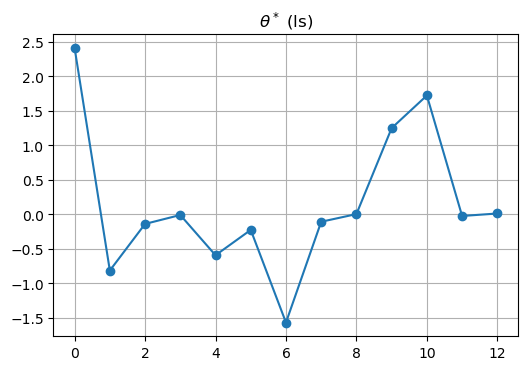

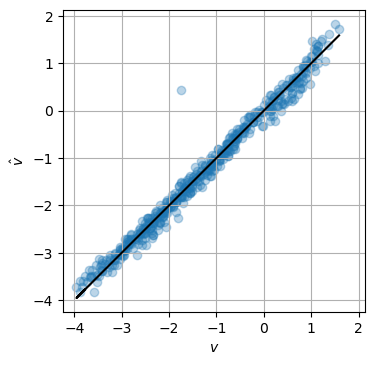

MSE: 0.03169255435216809
RMSE: 0.17802402745744209
Percentage error: 19.485403019425785 %


In [142]:
theta_ls = np.linalg.lstsq(x_train,y_train,rcond=None)[0]
y_pred = x_train.dot(theta_ls)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.plot(theta_ls,'o-')
plt.grid()
plt.title(r'$\theta^*$ (ls)')
plt.show()

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')


___

### Outlier rejection

In [143]:
# finding the outlier
np.argmax(y_pred-y_train)

100

In [144]:
# remove it
x_train = np.delete(x_train,100,0)
y_train = np.delete(y_train,100,0)
n_data = len(y_train)

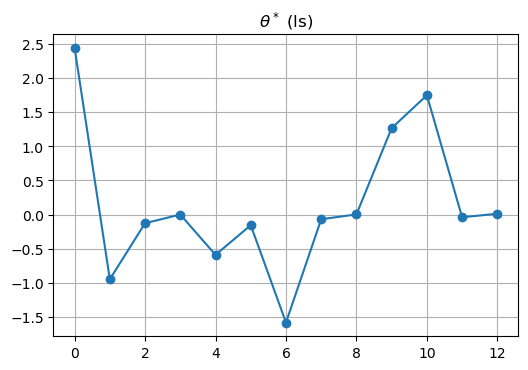

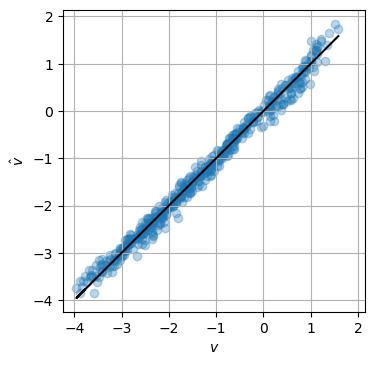

MSE: 0.02135375669532556
RMSE: 0.1461292465433445
Percentage error: 15.73457613237792 %


In [145]:
theta_ls = np.linalg.lstsq(x_train,y_train,rcond=None)[0]
y_pred = x_train.dot(theta_ls)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.plot(theta_ls,'o-')
plt.grid()
plt.title(r'$\theta^*$ (ls)')
plt.show()

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')


### Sparse modeling

Text(0, 0.5, 'cardinality')

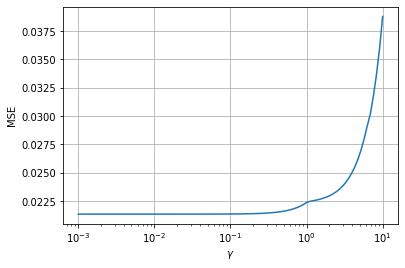

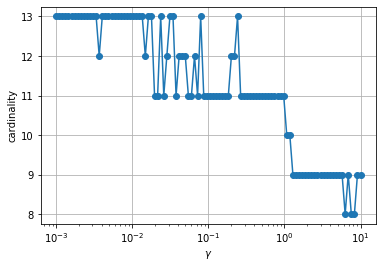

In [159]:
import cvxpy as cp

gamma = cp.Parameter(nonneg=True)
theta = cp.Variable(x_train.shape[1])
err = cp.sum_squares(x_train*theta-y_train)/n_data

obj = cp.Minimize( cp.sum_squares(y_train-x_train*theta) + gamma*cp.norm(theta,1) )
prob = cp.Problem(obj)

gamma_vals = np.logspace(-3,1,100)
mse = []
card = []

for val in gamma_vals:
    gamma.value = val
    prob.solve(solver=cp.ECOS, verbose=False)
    mse.append(err.value)
    card.append(np.sum((abs(theta.value)>1e-8)))

# Plot entries of x vs. gamma.
plt.figure()
plt.semilogx(gamma_vals, mse)
plt.grid()
plt.xlabel(r'$\gamma$')
plt.ylabel('MSE')

plt.figure()
plt.semilogx(gamma_vals, card, 'o-')
plt.grid()
plt.xlabel(r'$\gamma$')
plt.ylabel('cardinality')


### Choose $\gamma=0.4$.

[ 3.97018692e+00 -2.51624558e-10 -1.15380450e-01  1.99363160e-01
  1.04520936e-10 -1.35017108e-10 -1.51990306e+00 -3.85703751e-01
  1.91691033e-03  2.90065952e-10  3.32078989e-01 -7.09360319e-02
  8.63739937e-03]


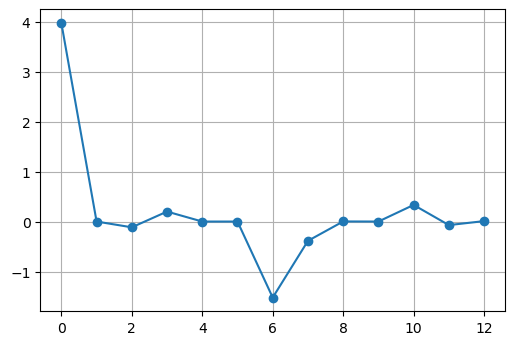

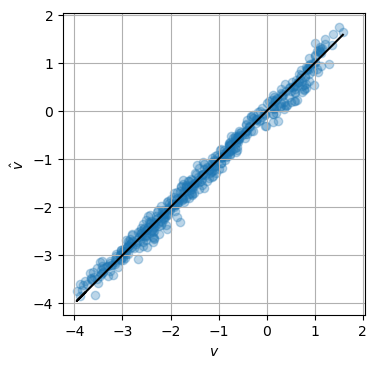

MSE: 0.02297372833007628
RMSE: 0.1515708690021809
Percentage error: 16.366076636493986 %


In [169]:
import cvxpy as cp

theta = cp.Variable(x_train.shape[1])
obj = cp.Minimize( cp.sum_squares(y_train-x_train*theta) + 2*cp.norm(theta,1) )

prob = cp.Problem(obj)
prob.solve(solver=cp.ECOS, verbose=False)
theta_opt = theta.value

print(theta_opt)

plt.figure(dpi=100)
plt.plot(theta_opt,'o-')
plt.grid()
plt.show()

y_pred = x_train.dot(theta_opt)
mse_ls = np.linalg.norm(y_train - y_pred)**2/n_data

plt.figure(dpi=100)
plt.scatter(y_train, y_pred, alpha=0.3)
plt.plot(y_train,y_train,'k-')
plt.xlabel(r'$v$')
plt.ylabel(r'$\hat{v}$')
plt.axis('square')
plt.grid()
plt.show()

print('MSE:',mse_ls)
print('RMSE:', np.sqrt(mse_ls))
print('Percentage error:', (np.exp(np.sqrt(mse_ls))-1)*100,'%')

### Final model

$$
\log(HFSS) \approx 3.970 -0.1154\log{b} +0.1994\log{c} -1.520\log{f} 
-0.3857 a +0.001917 b + 0.3321 d - 0.07094 e + 0.008637 f 
$$

Or in other words,

$$
    HFSS \approx 52.99 b^{-0.1154}c^{0.1994}f^{-1.520} 0.6800^a 1.002^b 1.394^d 0.9315^e 1.009^f
$$

- a: number of turns
- b: permitivity(surface)
- c: LS/LW
- d: SEP
- e: permitivity(subsidence)
- f: OD